# Assignment 7

## Prepare data for google svhn recognition

Prepare google street view house number data format 1.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import h5py
import tarfile
from IPython.display import display
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import tensorflow as tf

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Extract the dataset from the compressed .tar.gz file

In [2]:
data_root = '.' # change me to store data elsewhere

def maybe_extract(filename, force = False):
    filename = os.path.join(data_root, filename)
    root = os.path.splitext(os.path.splitext(filename)[0])[0] # remove .tar.gz
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    return root

svhn_train_folders = maybe_extract('train.tar.gz')
svhn_test_folders = maybe_extract('test.tar.gz')

.\train already present - Skipping extraction of .\train.tar.gz.
.\test already present - Skipping extraction of .\test.tar.gz.


In [4]:
trainFile = os.path.join(svhn_train_folders, 'digitStruct.mat')
testFile = os.path.join(svhn_test_folders, 'digitStruct.mat')
train_dataset = h5py.File(trainFile, 'r')  # read the .mat file
print(list(train_dataset.keys()))

['#refs#', 'digitStruct']


In [5]:
for name in train_dataset['digitStruct']:
    print(name)

bbox
name


In [6]:
print(train_dataset['digitStruct']['name'])
print(len(train_dataset['digitStruct']['name']))

<HDF5 dataset "name": shape (33402, 1), type "|O">
33402


In [68]:
name = train_dataset[train_dataset['digitStruct']['name'][0][0]].value
print(''.join(chr(c[0]) for c in name))

1.png


Take a look at the original images with bounding box.

In [72]:
def get_attrs(digit_struct_mat_file, index):
    """
    Returns a dictionary which contains keys: label, left, top, width and height, each key has multiple values.
    """
    attrs = {}
    f = digit_struct_mat_file
    item = f['digitStruct']['bbox'][index].item()
    for key in ['label', 'left', 'top', 'width', 'height']:
        attr = f[item][key]
        values = [f[attr.value[i].item()].value[0][0]
                  for i in range(len(attr))] if len(attr) > 1 else [attr.value[0][0]]
        attrs[key] = values
    return attrs

In [73]:
path_to_image_file = os.path.join(svhn_train_folders, '33000.png')
index = int(path_to_image_file.split('\\')[-1].split('.')[0]) - 1
print ('index %d: %s' % (index, path_to_image_file))

index 32999: .\train\33000.png


In [74]:
with h5py.File(trainFile, 'r') as digit_struct_mat_file:
    attrs = get_attrs(digit_struct_mat_file, index)
    print(attrs['label'])
    attrs_left, attrs_top, attrs_width, attrs_height = map(lambda x: [int(i) for i in x],
                                                       [attrs['left'], attrs['top'], 
                                                        attrs['width'], attrs['height']])

[9.0, 10.0]


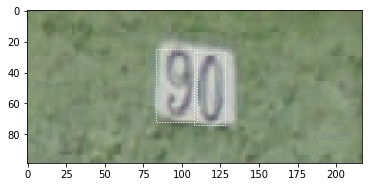

In [36]:
image = Image.open(path_to_image_file)
plt.figure()
currentAxis = plt.gca()
currentAxis.imshow(image)
for attr_left, attr_top, attr_width, attr_height in zip(attrs_left, attrs_top, 
                                                        attrs_width, attrs_height):
    currentAxis.add_patch(Rectangle((attr_left, attr_top), attr_width, attr_height, 
                                    fill=False, edgecolor='white', linestyle='dotted'))
plt.show()

### Read the dataset

In [7]:
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    in_file:              The input h5 matlab file
#    digitStruct_name   The h5 ref to all the file names
#    digitStruct_bbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, in_file):
        self.in_file = h5py.File(in_file, 'r')
        self.digitStruct_name = self.in_file['digitStruct']['name']
        self.digitStruct_bbox = self.in_file['digitStruct']['bbox']
        
# get_name returns the 'name' string of the picture given the index in digitStruct
    def get_name(self, index):
        return ''.join(chr(c[0]) for c in self.in_file[self.digitStruct_name[index][0]].value)
    
# get_attr get attr when there is one or more bbox
    def get_attr(self, attr):
        if (len(attr) > 1):
            attr = [self.in_file[attr.value[i].item()].value[0][0] for i in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# get_bbox returns a dict of data given the index
    def get_bbox(self, index):
        bbox = {}
        bb = self.digitStruct_bbox[index].item()
        bbox['label'] = self.get_attr(self.in_file[bb]['label'])
        bbox['left'] = self.get_attr(self.in_file[bb]['left'])
        bbox['top'] = self.get_attr(self.in_file[bb]['top'])
        bbox['width'] = self.get_attr(self.in_file[bb]['width'])
        bbox['height'] = self.get_attr(self.in_file[bb]['height'])
        return  bbox
    
    def get_digitStruct(self,index):
        digitStruct_dic = self.get_bbox(index)
        digitStruct_dic['name'] = self.get_name(index)
        return digitStruct_dic
    
    def get_all_digitStruct(self):
        return [self.get_digitStruct(i) for i in range(len(self.digitStruct_name))]
    
# get_all_digitStruct_by_digit returns a restructured version of the dataset
#      a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box

    def get_all_digitStruct_by_digit(self):
        all_digitStruct = self.get_all_digitStruct()
        result = []
    
        for i in range(len(all_digitStruct)):
            item = {'name' : all_digitStruct[i]['name']}
            digits = []
            for j in range(len(all_digitStruct[i]['label'])):
                digit = {}
                digit['label'] = all_digitStruct[i]['label'][j]
                digit['left'] = all_digitStruct[i]['left'][j]
                digit['top'] = all_digitStruct[i]['top'][j]
                digit['height'] = all_digitStruct[i]['height'][j]
                digit['width'] = all_digitStruct[i]['width'][j]
                digits.append(digit)
            item['bbox'] = digits
            result.append(item)
        
        return result      

In [8]:
print(trainFile)
print(testFile)


.\train\digitStruct.mat
.\test\digitStruct.mat


In [9]:
train = DigitStructFile(trainFile)
train_data = train.get_all_digitStruct_by_digit()
test = DigitStructFile(testFile)
test_data = test.get_all_digitStruct_by_digit()

In [10]:
print(len(train_data))
print(train_data[0])
print(len(test_data))
print(test_data[0])

33402
{'bbox': [{'height': 219.0, 'width': 81.0, 'top': 77.0, 'left': 246.0, 'label': 1.0}, {'height': 219.0, 'width': 96.0, 'top': 81.0, 'left': 323.0, 'label': 9.0}], 'name': '1.png'}
13068
{'bbox': [{'height': 30.0, 'width': 19.0, 'top': 7.0, 'left': 43.0, 'label': 5.0}], 'name': '1.png'}


Save the data

In [11]:
pickle_file = os.path.join(data_root, 'google_svhn_format1.pickle')

if os.path.exists(pickle_file):
      print('%s already present - Skipping pickling.' % pickle_file)
else:
    try:
      f = open(pickle_file, 'wb')
      save = {
        'train_data': train_data,
        'test_data': test_data,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise

In [12]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 11909844


Open pickle file:

In [3]:
pickle_file = 'google_svhn_format1.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_data = save['train_data']
    test_data = save['test_data']
    del save
    print('Train_data', len(train_data))
    print('Test_data', len(test_data))
    print(len(train_data))
    print(train_data[0])
    print(len(test_data))
    print(test_data[0])

Train_data 33402
Test_data 13068
33402
{'name': '1.png', 'bbox': [{'left': 246.0, 'width': 81.0, 'top': 77.0, 'height': 219.0, 'label': 1.0}, {'left': 323.0, 'width': 96.0, 'top': 81.0, 'height': 219.0, 'label': 9.0}]}
13068
{'name': '1.png', 'bbox': [{'left': 43.0, 'width': 19.0, 'top': 7.0, 'height': 30.0, 'label': 5.0}]}


### Create dataset for training and testing

Crop the boundry boxes from the image, and create dataset as N x image_size x image_size numpy array, create label as N x 6 numpy array (first one for length, then five digits).

In [4]:
class Dataset:
    
    def __init__(self, digitStruct, image_folder, image_size):
        self.digitStruct = digitStruct
        self.image_folder = image_folder
        self.image_size = image_size
        
    def set_dataset(self):
        self.dataset = np.ndarray(shape = (len(self.digitStruct), self.image_size,
                                           self.image_size), dtype = np.float32)
        # 0 length, 1-5 digit labels, where 1-9 representing 1-9, 10 represents 0 or none
        self.labels = np.ones(shape= (len(self.digitStruct), 6), dtype = np.int32) * 10
    
    def get_dataset(self):
        self.set_dataset()
        for i in range(len(self.digitStruct)):
            image_file = os.path.join(self.image_folder, self.digitStruct[i]['name'])
            im = Image.open(image_file)
            
            bbox = self.digitStruct[i]['bbox']
            
            if len(bbox) > 5:
                print(image_file, 'has more than 5 digits.')
            else:
                self.labels[i,0] = len(bbox)
                self.labels[i,1:len(bbox)+1] = [int(j['label']) for j in bbox]
            
            # collect the dimension parameters for all the bbox in the image
            left = [int(j['left']) for j in bbox]
            top = [int(j['top']) for j in bbox]
            width = [int(j['width']) for j in bbox]
            height = [int(j['height']) for j in bbox]
            
            # get the crop box dimension: left, top, right, bottom
            crop_box = self.get_crop_box(im, left, top, width, height)
            
            crop_size = (self.image_size, self.image_size)
            region = im.crop(crop_box).resize(crop_size)
            region = self.rgb_to_grey(region)
            region = self.normalization(region)
            self.dataset[i,:,:] = region
        
        print('dataset:', self.dataset.shape)
        print('labels:', self.labels.shape)
        
        return self.dataset, self.labels
    
    def get_crop_box(self, im, left, top, width, height):
                
        im_height = max(top) + max(height) - min(top)
        im_width = max(left) + max(width) - min(left)
        
        # make the crop image a bit bigger 
        im_left = max((min(left) - 0.05*im_width), 0)
        im_top = max((min(top) - 0.05*im_height), 0)
        im_right = min((min(left) + im_width * 1.05), im.size[0])
        im_bottom = min((min(top) + im_height * 1.05), im.size[1])
        
        return (im_left, im_top, im_right, im_bottom)
    
    def rgb_to_grey(self, image):
        return np.dot(np.array(image, dtype=np.float32), [0.299, 0.587, 0.114])
    # normalize the image to have 0 mean, and scale from -0.5 to 0.5
    def normalization(self, image):
        mean = np.mean(image, dtype = np.float32)
        std = np.std(image, dtype = np.float32)
        return (image - mean)/(std * 2)

In [5]:
data_root = '.'
image_size = 32

train_image_folder = os.path.join(data_root, 'train')
test_image_folder = os.path.join(data_root, 'test')

train_dataset_obj = Dataset(train_data, train_image_folder, image_size)
train_dataset, train_labels = train_dataset_obj.get_dataset()

test_dataset_obj = Dataset(test_data, test_image_folder, image_size)
test_dataset, test_labels = test_dataset_obj.get_dataset()

.\train\29930.png has more than 5 digits.
dataset: (33402, 32, 32)
labels: (33402, 6)
dataset: (13068, 32, 32)
labels: (13068, 6)


In [6]:
train_dataset = np.delete(train_dataset, 29929, axis = 0)
train_labels = np.delete(train_labels, 29929, axis = 0)

Normalize the dataset to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

In [7]:
print(np.mean(train_dataset))
print(np.std(train_dataset))
print(np.mean(test_dataset))
print(np.std(test_dataset))

2.55542e-09
0.5
1.6018e-09
0.5


In [8]:
train_dataset_backup = train_dataset
train_labels_backup = train_labels
test_dataset_backup = test_dataset
test_labels_backup = test_labels

In [9]:
import random

def display_sample_image(dataset, label, title = None):
    if title:
        plt.suptitle(title, fontsize = 12)
        
    items = random.sample(range(label.shape[0]), 12)
    
    for i,item in enumerate(items):
        plt.subplot(3,4,i+1)
        plt.axis('off')
        plt.title(label[item][1:(label[item][0] + 1)])
        plt.imshow(dataset[item, :, :])
        
    plt.show()

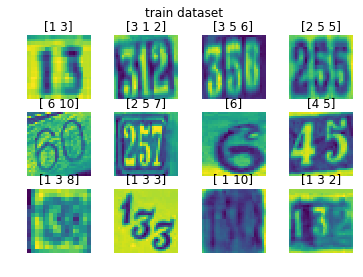

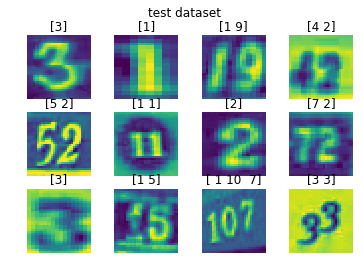

In [10]:
display_sample_image(train_dataset_backup, train_labels_backup, 'train dataset')
display_sample_image(test_dataset_backup, test_labels_backup, 'test dataset')

Create validation dataset:

In [11]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

In [12]:
valid_size = 5000

valid_dataset = train_dataset[:valid_size, :, :]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:, :, :]
train_labels = train_labels[valid_size:]

print(train_dataset.shape, train_labels.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(28401, 32, 32) (28401, 6)
(13068, 32, 32) (13068, 6)
(5000, 32, 32) (5000, 6)


Display a few sample images:

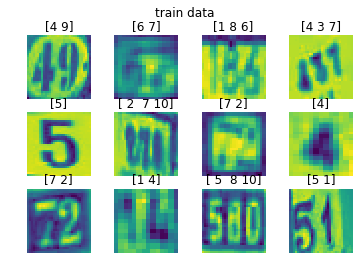

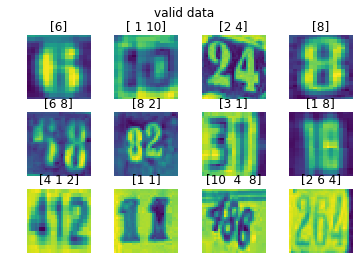

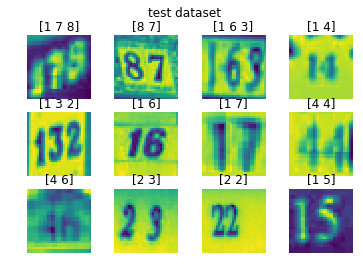

In [13]:
display_sample_image(train_dataset, train_labels, 'train data')
display_sample_image(valid_dataset, valid_labels, 'valid data')
display_sample_image(test_dataset, test_labels, 'test dataset')

Save dataset:

In [14]:
pickle_file = 'google_svhn_multi_digits_version3.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print("Done")
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Done
